In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import NMF

from src.playervectors import PlayerHeatMap
from src.playervectors import PlayerVectors

from src.ExtractData import (
    ExtractCoordinates, 
    ExtractPlayers, 
    ExtractTeams, 
    ExtractMinutesPlayed, 
    ExtractGoalkeepers 
)

## Load: Players

In [2]:
df_players = pd.read_csv('event_streams/players.csv')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


#### Extract Player Information

In [3]:
# Mapping {playerID -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

In [4]:
df_playerank = pd.read_csv('event_streams/playerank.csv')
df_playerank.head()

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90


#### Extract Goalkeepers

In [5]:
keepers = ExtractGoalkeepers(df_players, wy_code='name', keeper_str='Goalkeeper')

#### Extract Played Minutes

In [6]:
# Extract played minutes
# Mapping {playerID -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Event Streams

In [7]:
df_events = pd.read_csv('event_streams/actions.csv')
df_events.head()

,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462726 entries, 0 to 2462725
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   game_id            int64  
 2   period_id          int64  
 3   time_seconds       float64
 4   team_id            int64  
 5   player_id          int64  
 6   start_x            float64
 7   start_y            float64
 8   end_x              float64
 9   end_y              float64
 10  original_event_id  float64
 11  bodypart_id        int64  
 12  type_id            int64  
 13  result_id          int64  
 14  action_id          int64  
 15  type_name          object 
 16  result_name        object 
 17  bodypart_name      object 
dtypes: float64(6), int64(9), object(3)
memory usage: 338.2+ MB


#### Normalize Playing Direction

In [9]:
df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

#### Select Relevant Actions with respect to thier x,y coordinates

##### How does ExtractCoordinates work?

```python
>>> df
       playerID action   x   y
    0         1   pass  55  45
    1         1   pass  50  40
    2         1   shot  53  43
    3         1   shot  54  44
    4         2   pass  43  33
    5         2  cross  43  23
    6         2  cross  42  32
    7         3   pass  17  57
    8         3   pass  10  50
    9         3   pass  15  55
    
    >>> action_coordinates = ExtractCoordinates(df=df,
    ...                                         column_player_id='playerID',
    ...                                         column_event_name='action',
    ...                                         column_x='x',
    ...                                         column_y='y',
    ...                                         actions=['pass', 'shot', 'cross'])
    >>> action_coordinates
    {'pass': {1: ([55, 50], [45, 40]), 2: ([43], [33]), 3: ([17, 10, 15], [57, 50, 55])},
     'shot': {1: ([53, 54], [43, 44])},
     'cross': {2: ([43, 42], [23, 32])}}
```

In [10]:
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
coordinates = ExtractCoordinates(df=df_events, column_player_id='player_id', column_event_name='type_name', column_x='start_x', column_y='start_y', actions=['pass', 'cross', 'dribble', 'shot'])

#### Remove Goalkeepers

In [11]:
# Remove goalkeepers from the dictionary safely
for action, player_coordinates in coordinates.items():
    # Create a list of player IDs to be removed
    players_to_remove = [player_id for player_id in player_coordinates if player_id in keepers]
    
    # Remove players from the action dictionary
    for player_id in players_to_remove:
        del coordinates[action][player_id]

## Load: Teams

In [12]:
df_teams = pd.read_csv('event_streams/teams.csv')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Extract Team Information

In [13]:
# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

In [14]:
# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Building Player Vectors

### 1. Selecting Relevant Action Types
Let $k_t$ be the number of principal components chosen to compress heatmaps of action type $t$.

According to the paper, $k_t$ with $t \in \{\text{shot}, \text{cross}, \text{dribble}, \text{pass}\}$ with corresponding components $\{4, 4, 5, 5\}$ is the minimal number of components needed to explain
70% of the variance in the heatmaps of action type $t$.

This parameter setting
was empirically found to work well because of the high variability of players
positions in their actions (see Challenge 1 in Section 2 in the paper).

Ignoring 30% of the variance allows to summarize a player’s playstyle only by his dominant regions
on the field rather than model every position on the field he ever occupied.

### 2. Constructing Heatmaps

* 2.1 Counting

* 2.2 Normalizing

* 3.3 Smoothing

### 3. Compressing Heatmaps to Vectors

* 3.1 Reshaping

* 3.2 Construct the matrix M

* 3.3 Compress matrix M by applying non-negative matrix factorization (NMF)

### 4. Assembling Player Vectors

In [15]:
# Creating a PlayerVectors object
PVs = PlayerVectors(shape=(50, 50),
                    sigma=4.0,
                    actions=['shot', 'cross', 'dribble', 'pass'],
                    components=[4, 4, 5, 5])

PVs.fit(coordinates=coordinates,
        minutes_played=minutes_played,
        player_names=playersID_to_name,
        verbose=True)

Action: shot	Shape of M: (2500, 2798)	Shape of W: (2500, 4)	Shape of H: (4, 2798)
Action: cross	Shape of M: (2500, 2798)	Shape of W: (2500, 4)	Shape of H: (4, 2798)
Action: dribble	Shape of M: (2500, 2798)	Shape of W: (2500, 5)	Shape of H: (5, 2798)
Action: pass	Shape of M: (2500, 2798)	Shape of W: (2500, 5)	Shape of H: (5, 2798)


## 18 Components of our Player Vectors 
The 18 components of our player vectors constructed by compressing heatmaps
of shots (1-4), crosses (5-8), dribbles (9-13), and passes (14-18) with non-negative
matrix factorization

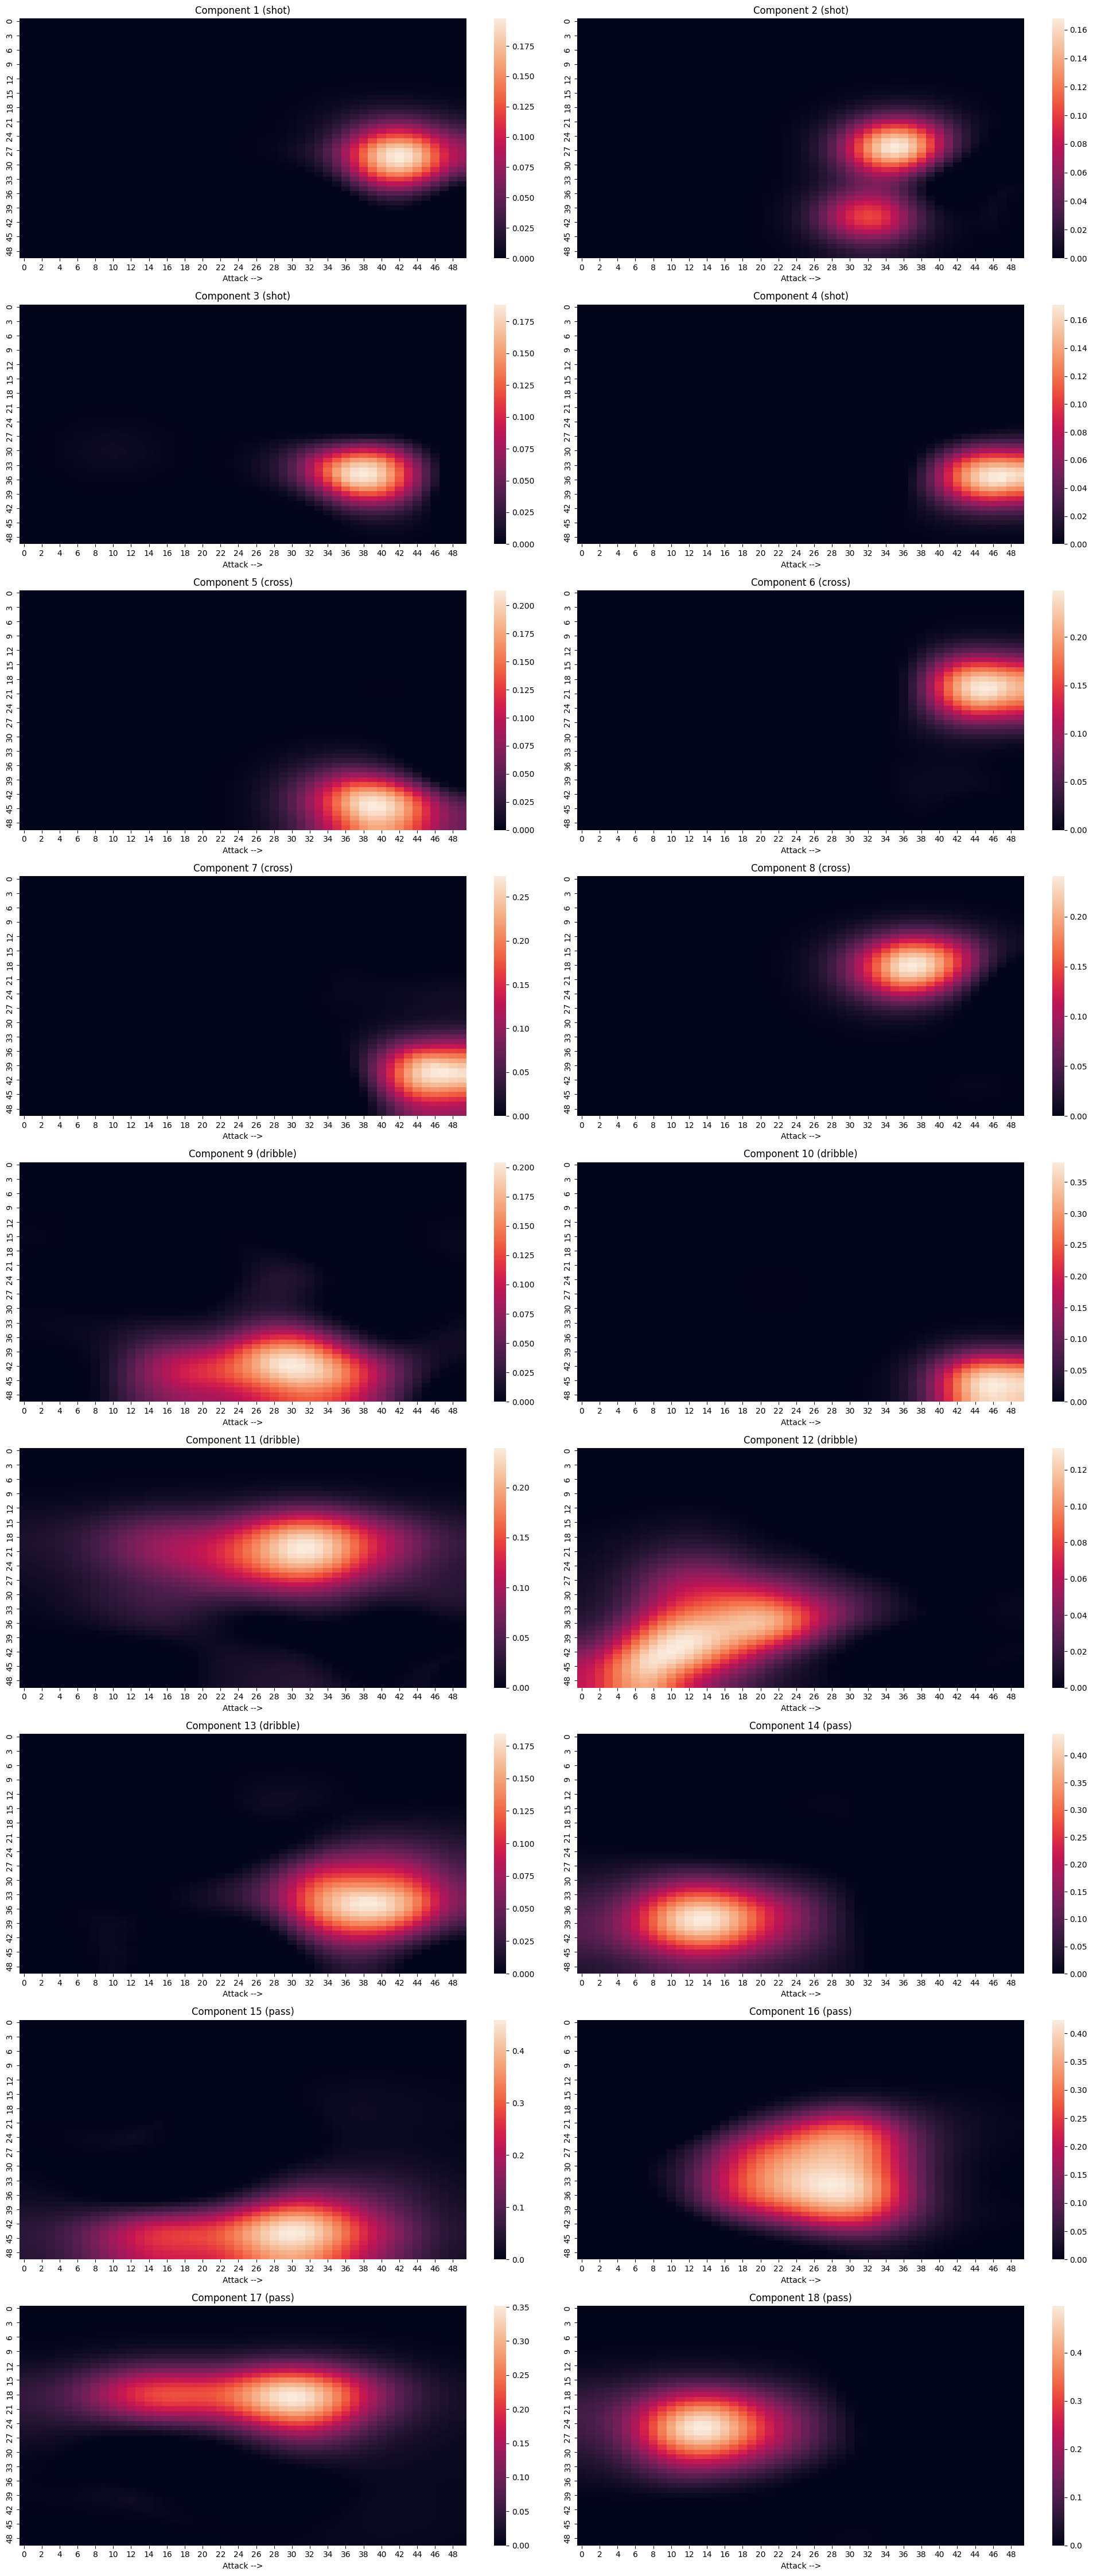

In [16]:
PVs.plot_principle_components(figsize=(20, 45))
plt.show()

### Interpretation

* Component (1): Close shot

* Component (2): Far shot

* Component (3): Far shot right

* Component (4): Close shot right

* Component (5): R. corner cross

* Component (6): L. backline cross

* Component (7): R. flank cross

* Component (8): L. far backline cross

* Component (9): Center dribble (front)

* Component (10): L. flank dribble

* Component (11): R. corner dribble

* Component (12): Center dribble (back)

* Component (13): L. flank dribble

* Component (14): Center pass

* Component (15): Right flank pass

* Component (16): Right back pass

* Component (17): Left flank pass

* Component (17): Center pass (back)

## Boxplot Weight Distribution

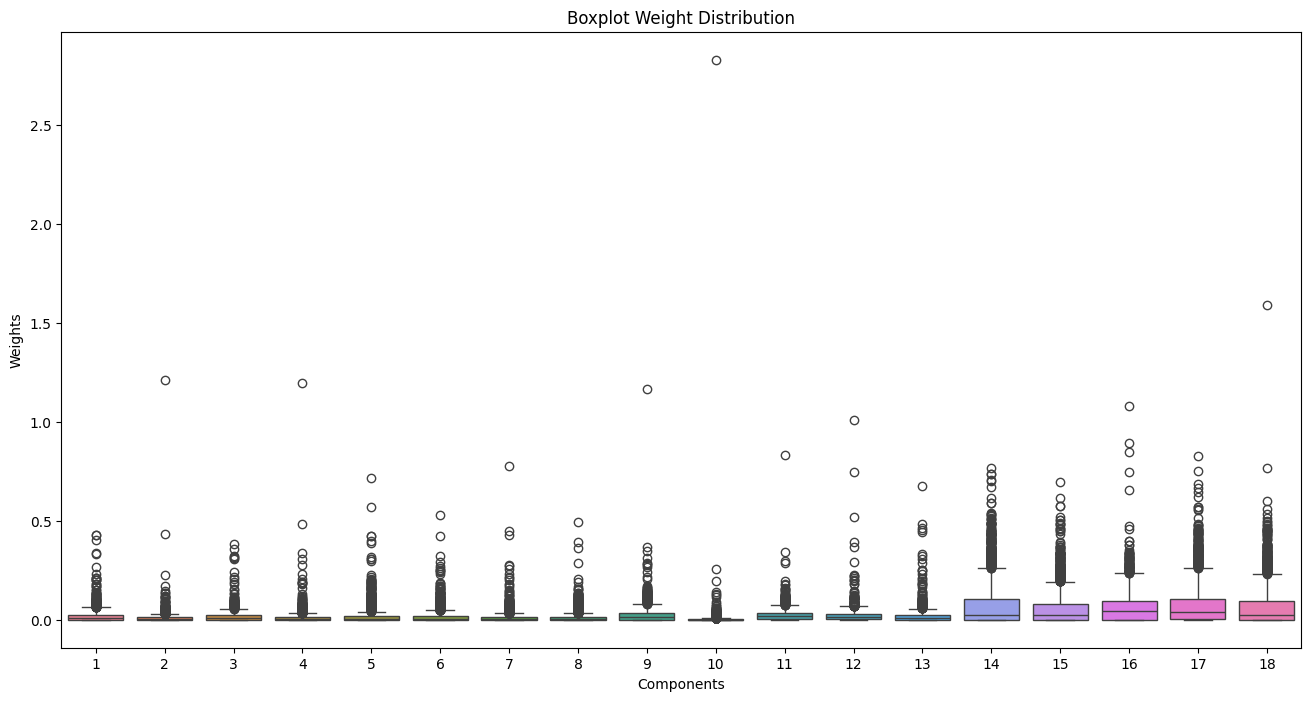

In [17]:
weights = [player_vector for id, player_vector in PVs.player_vectors.items() if len(player_vector) == 18 and id in playersID_to_name]
data = pd.DataFrame(weights, columns=[n for n in range(1, 19)])

plt.figure(figsize=(16, 8))
plt.title('Boxplot Weight Distribution')
sns.boxplot(data=data)
plt.xlabel('Components')
plt.ylabel('Weights')
plt.show()

## Weights of the 18 Component Player Vectors

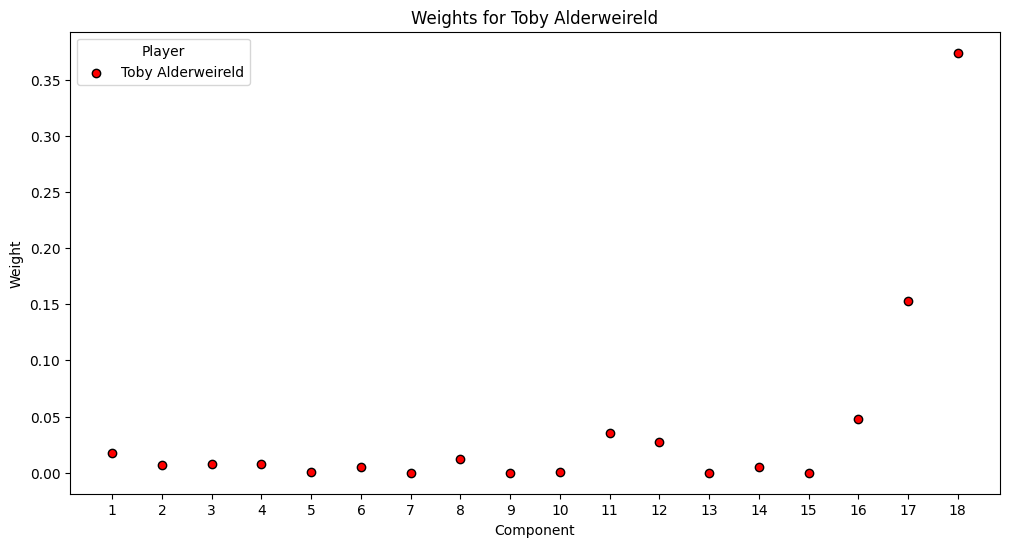

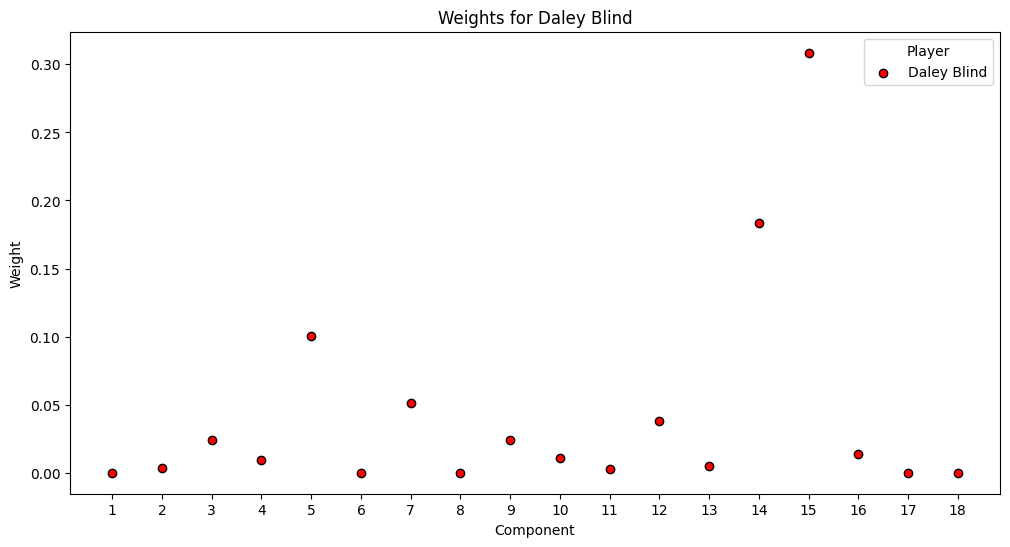

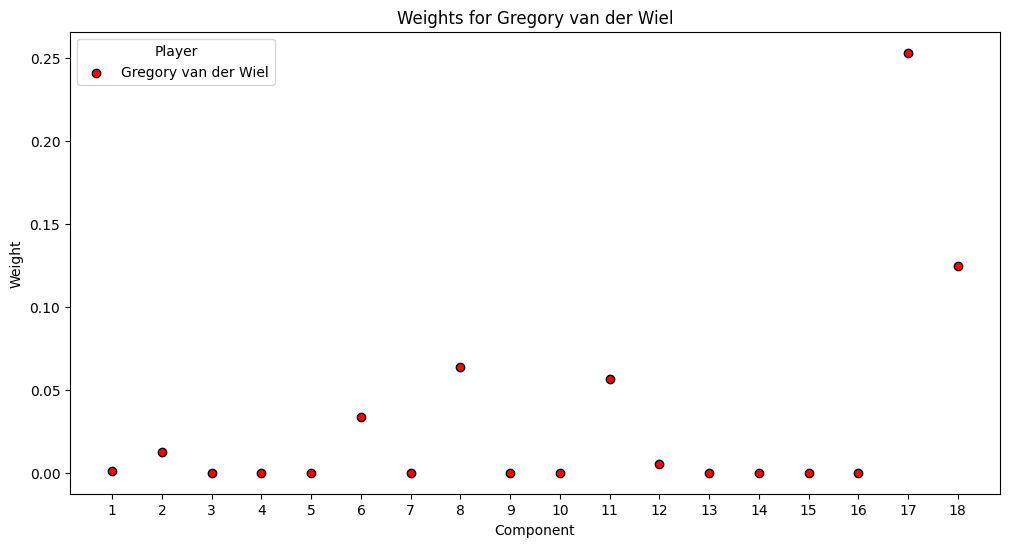

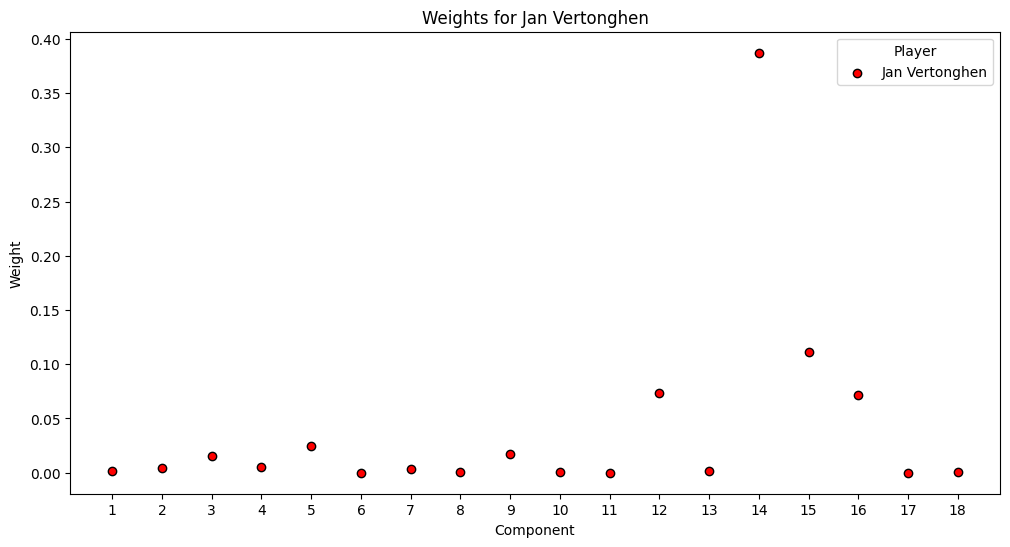

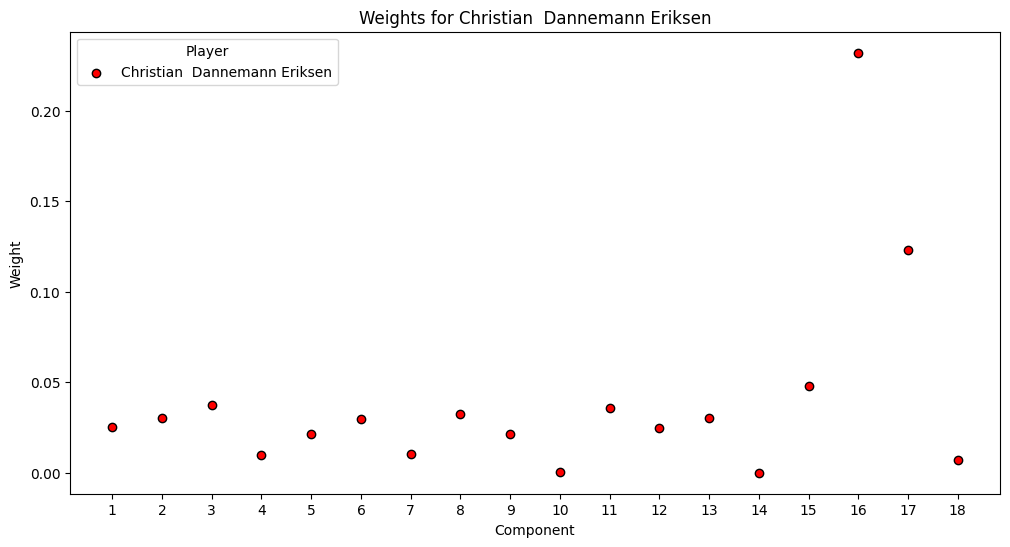

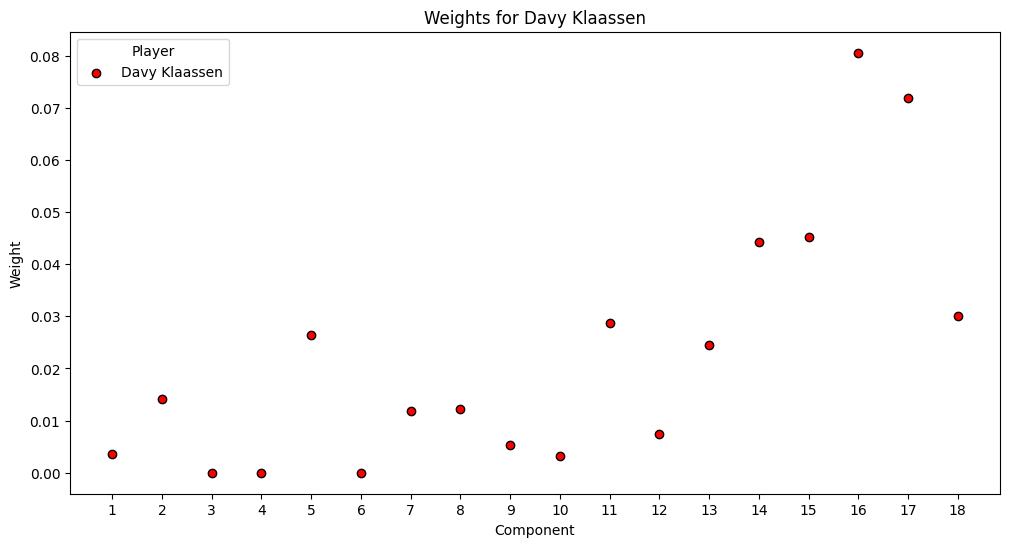

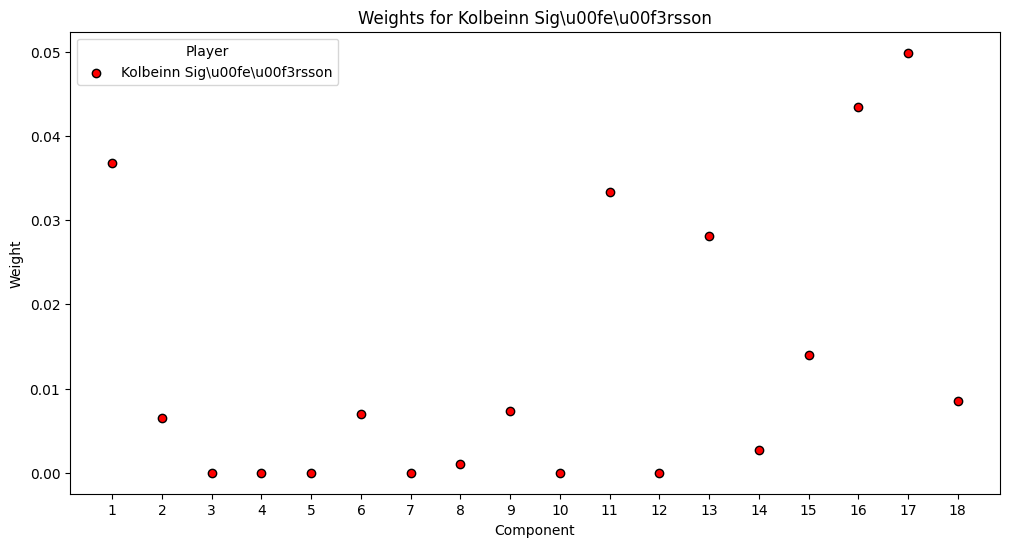

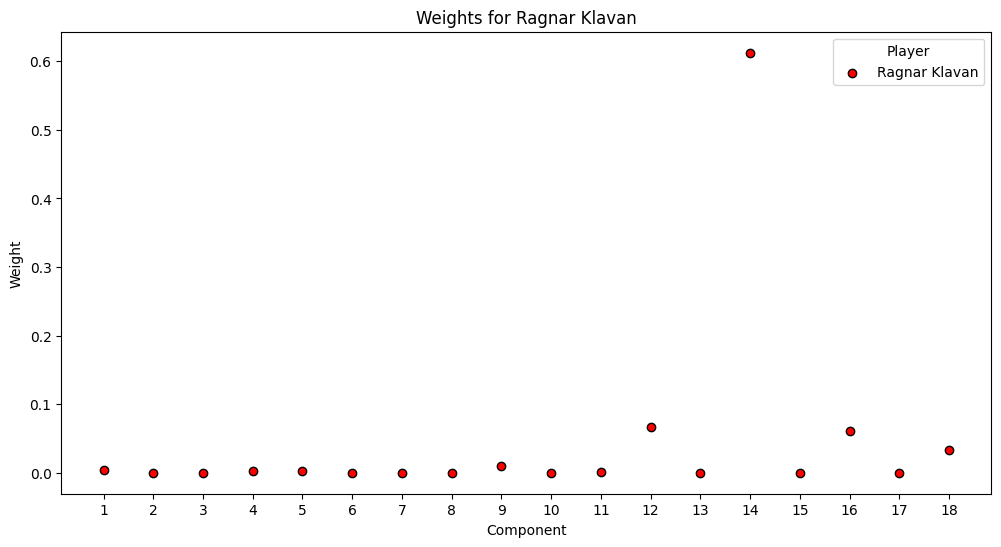

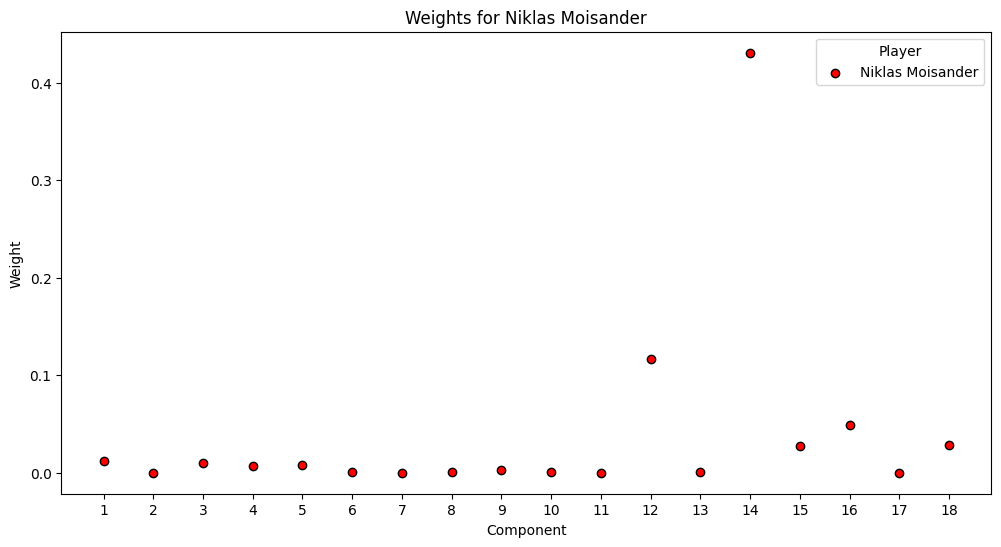

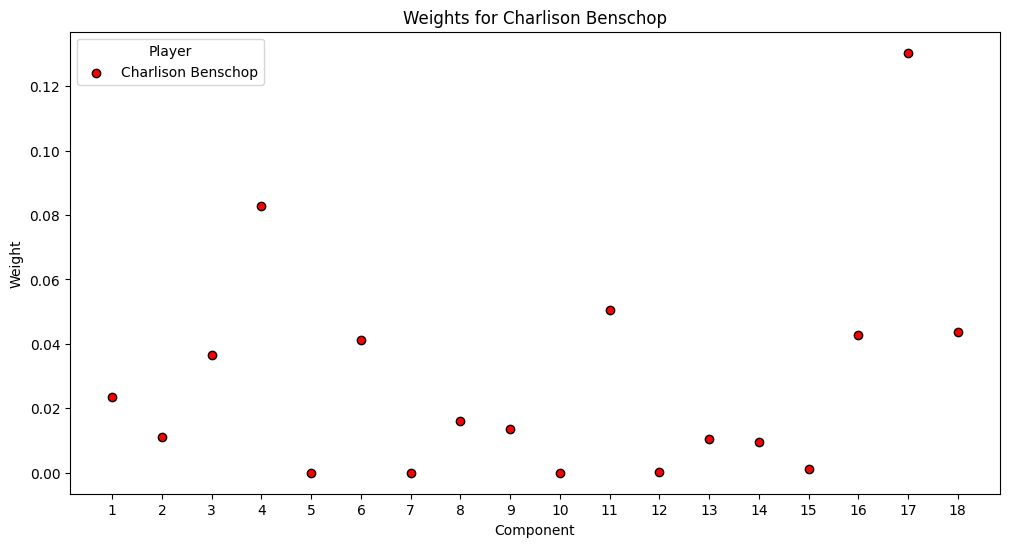

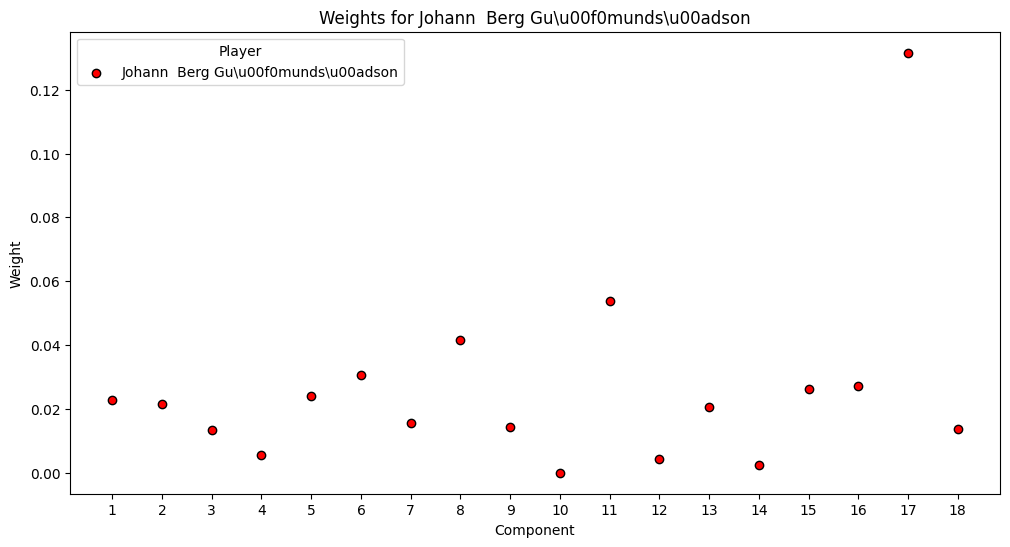

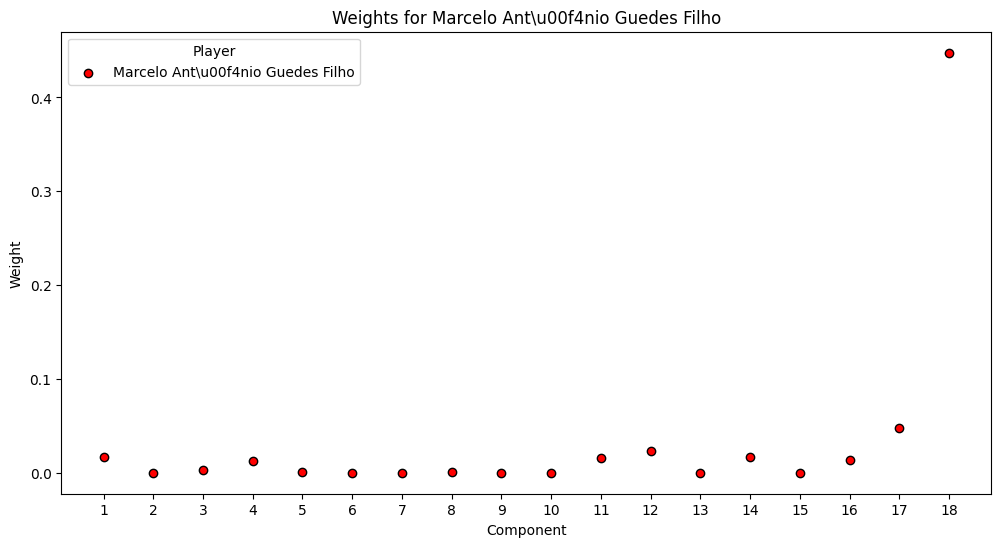

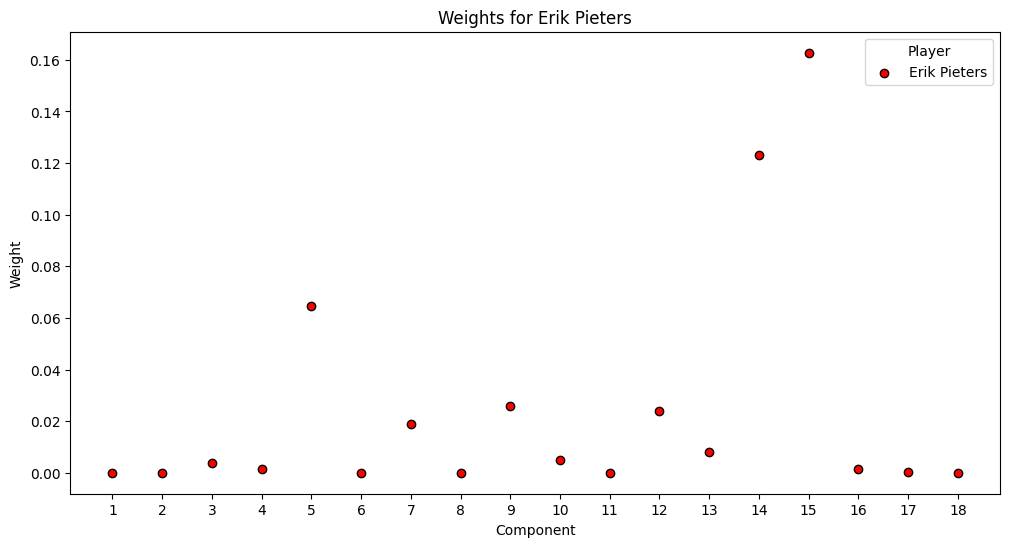

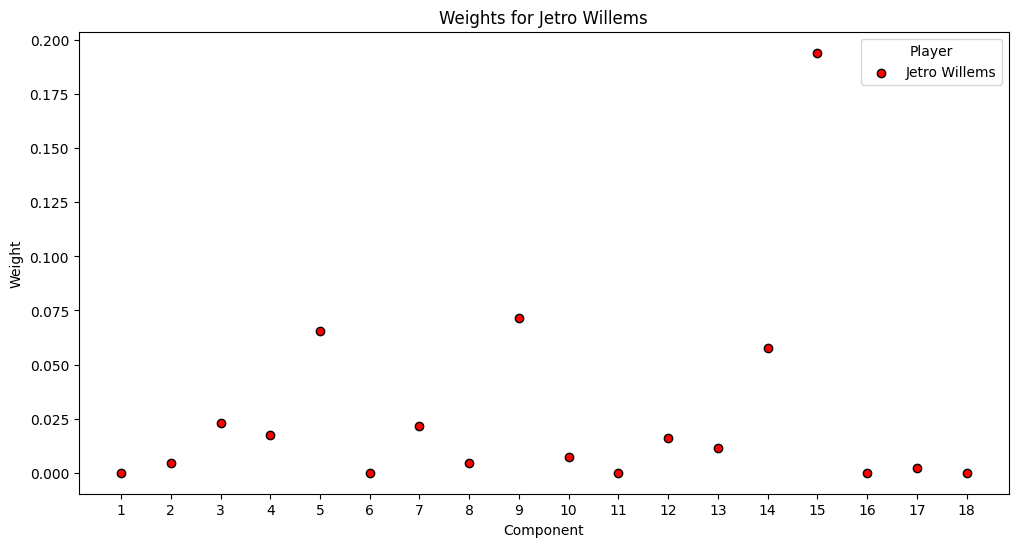

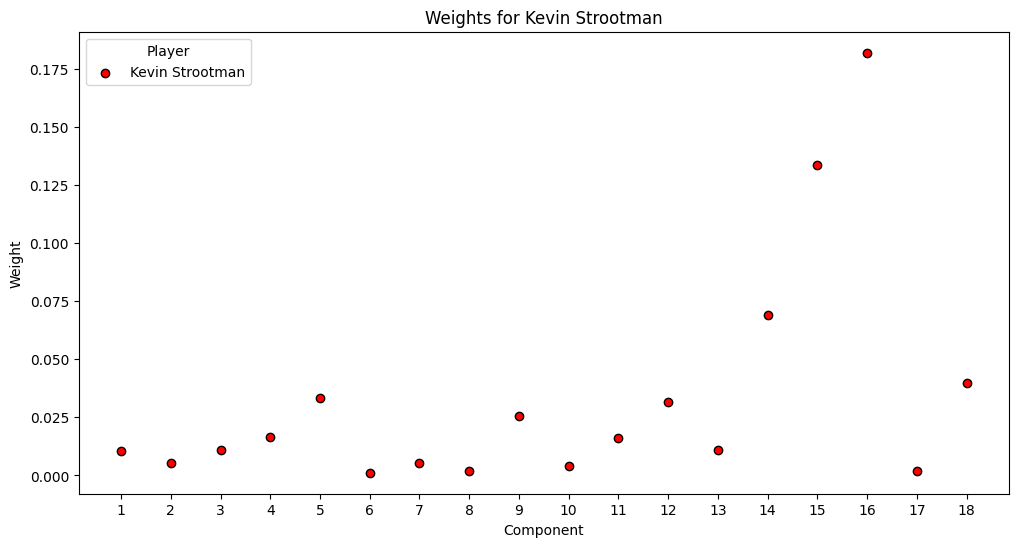

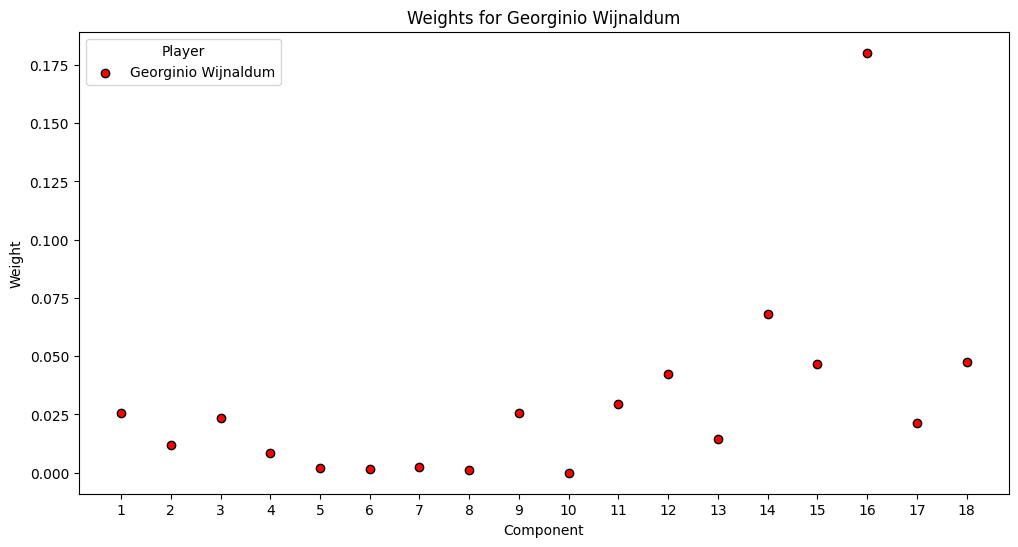

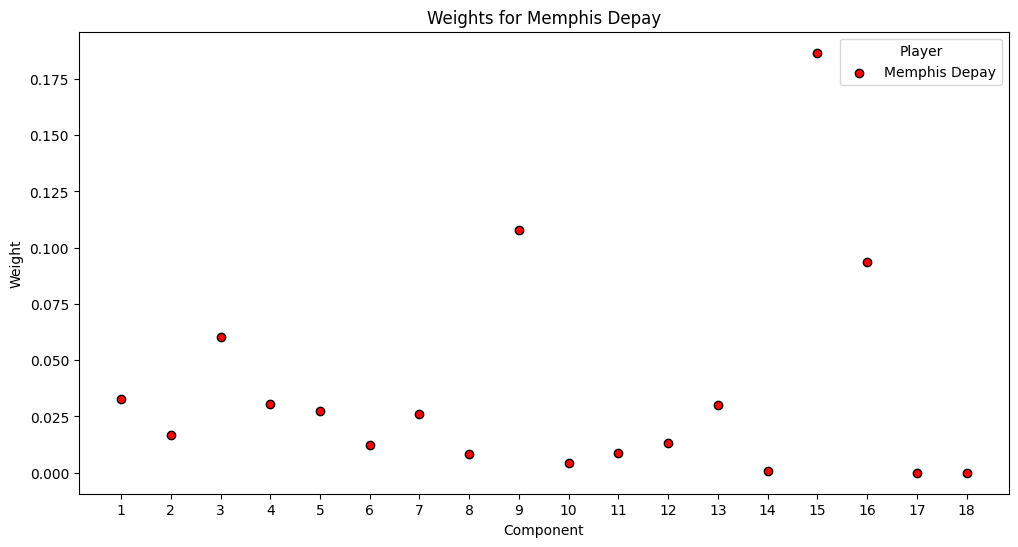

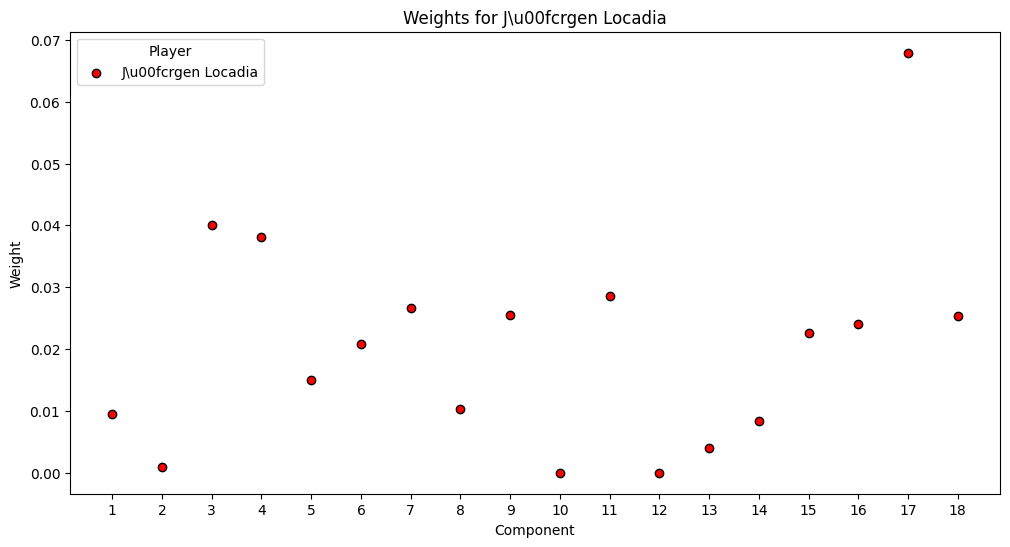

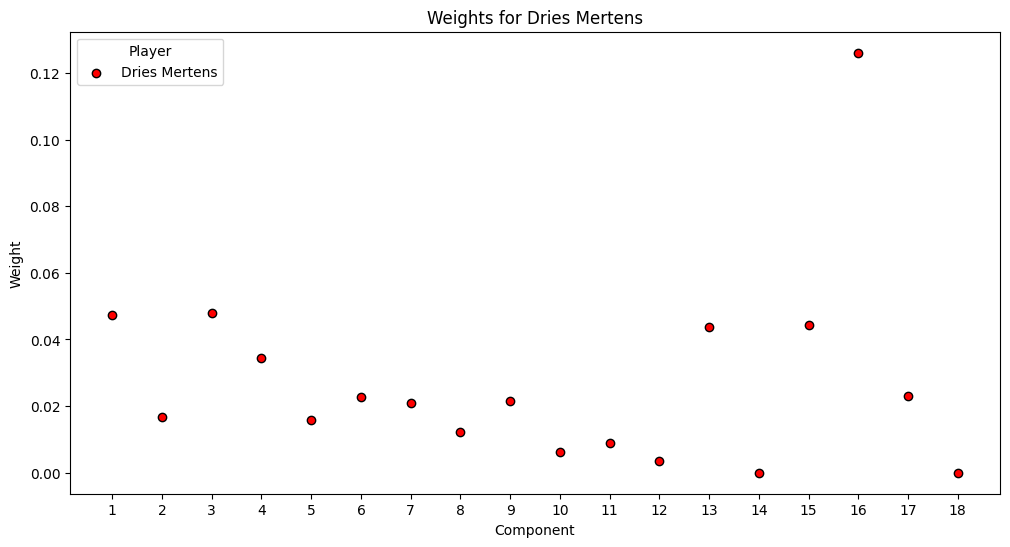

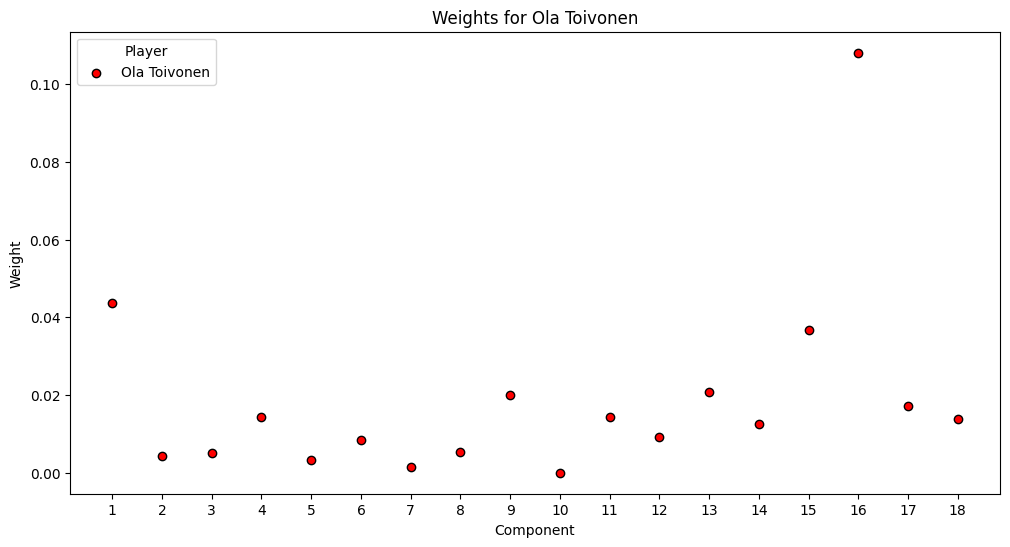

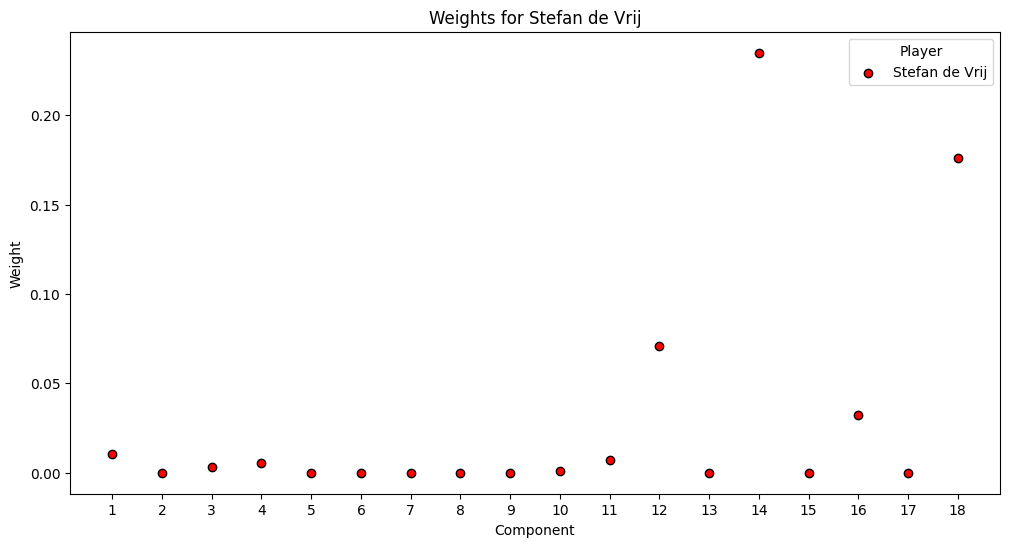

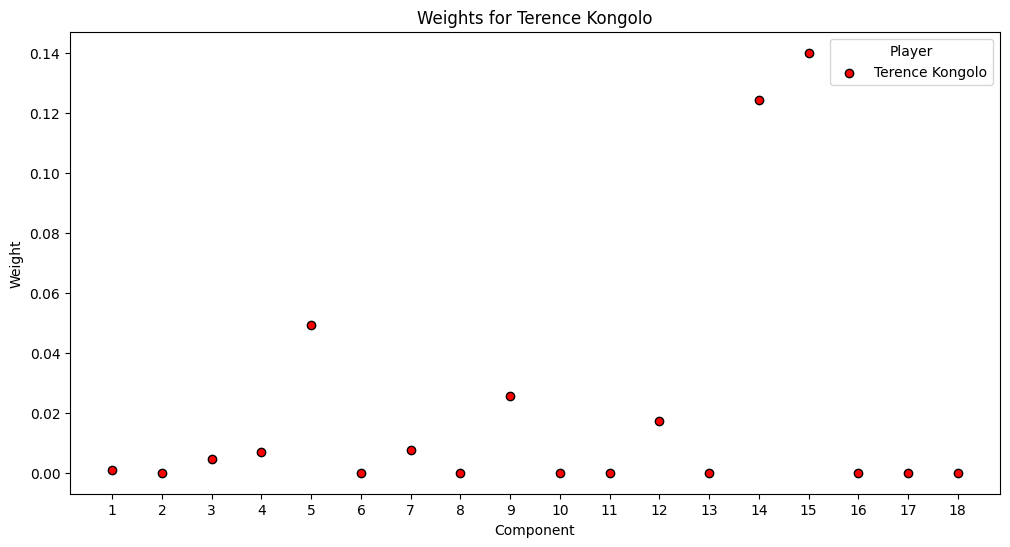

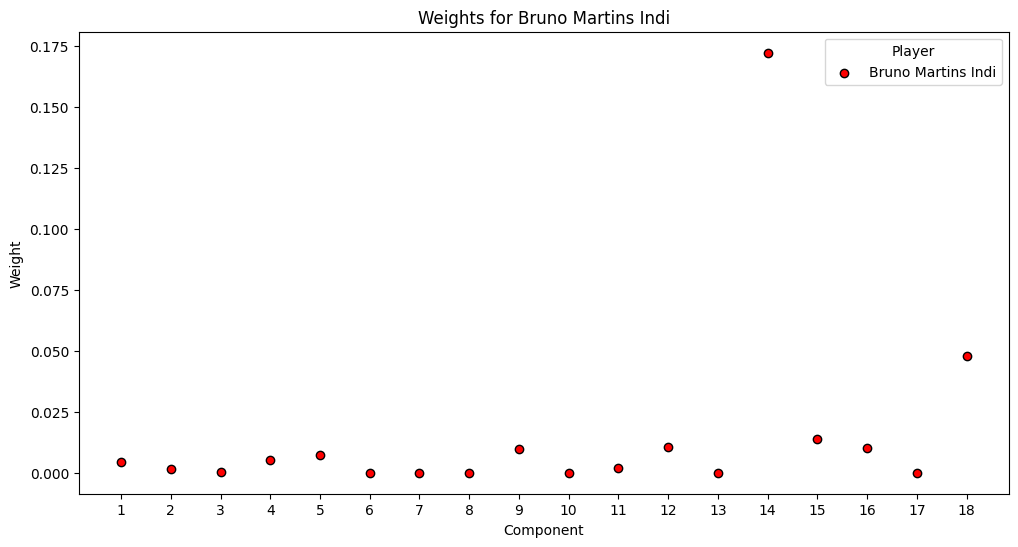

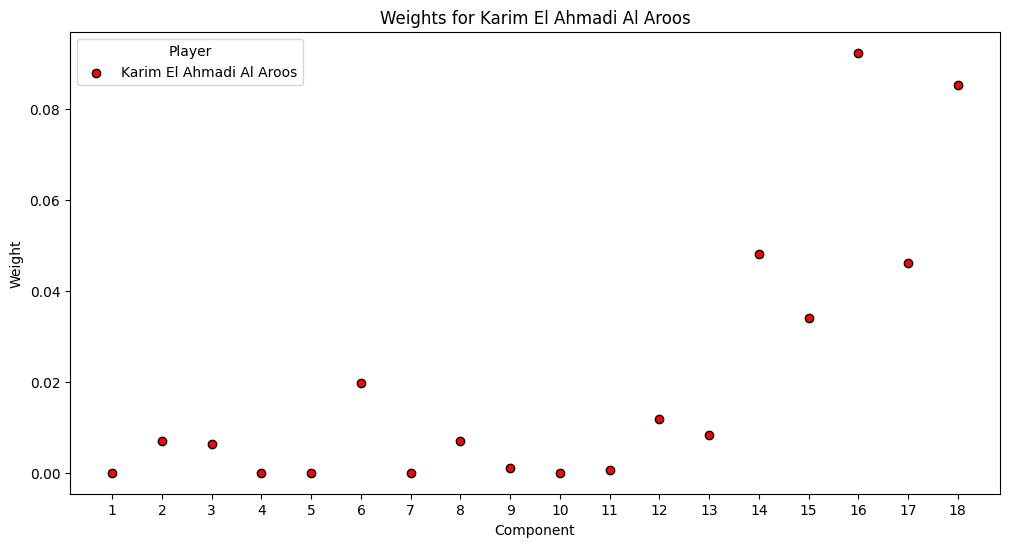

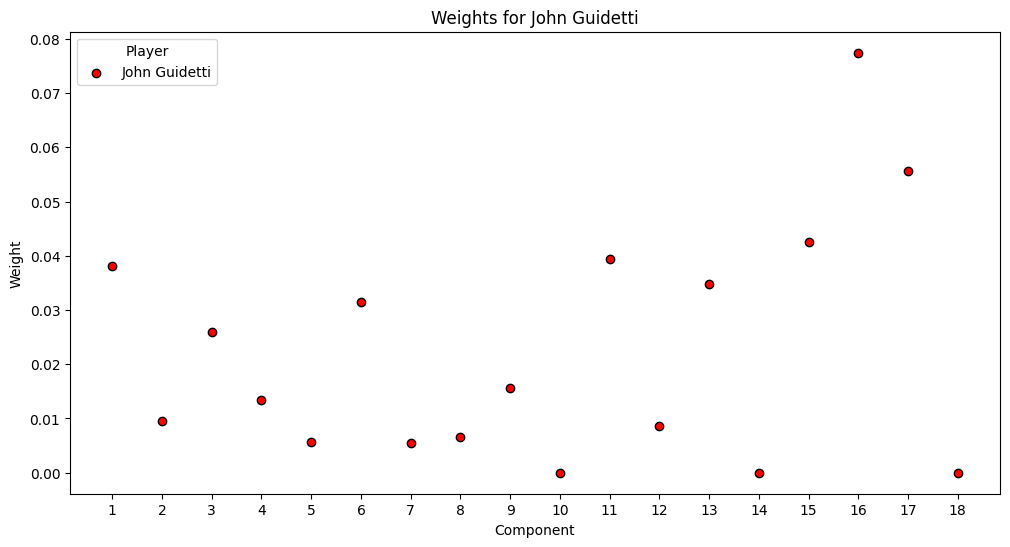

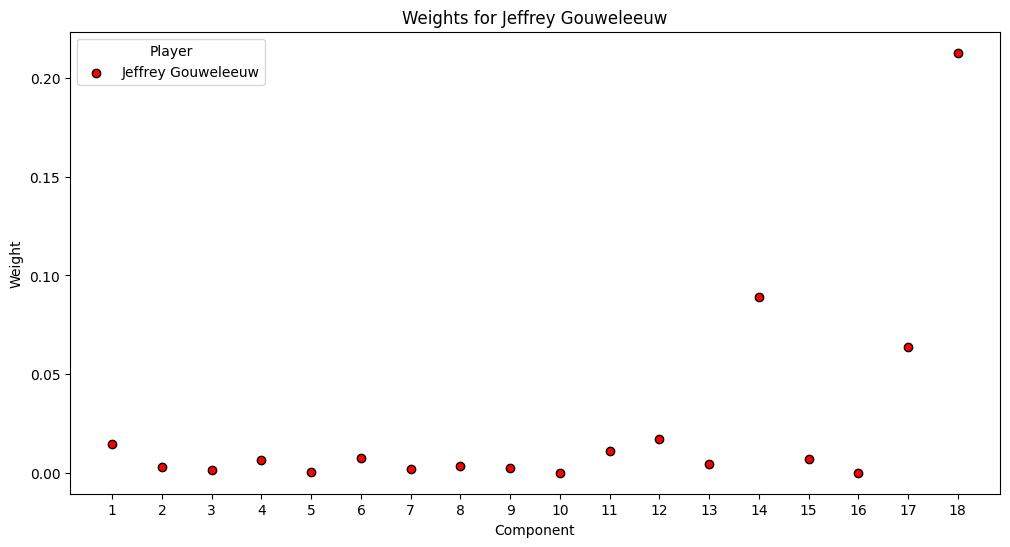

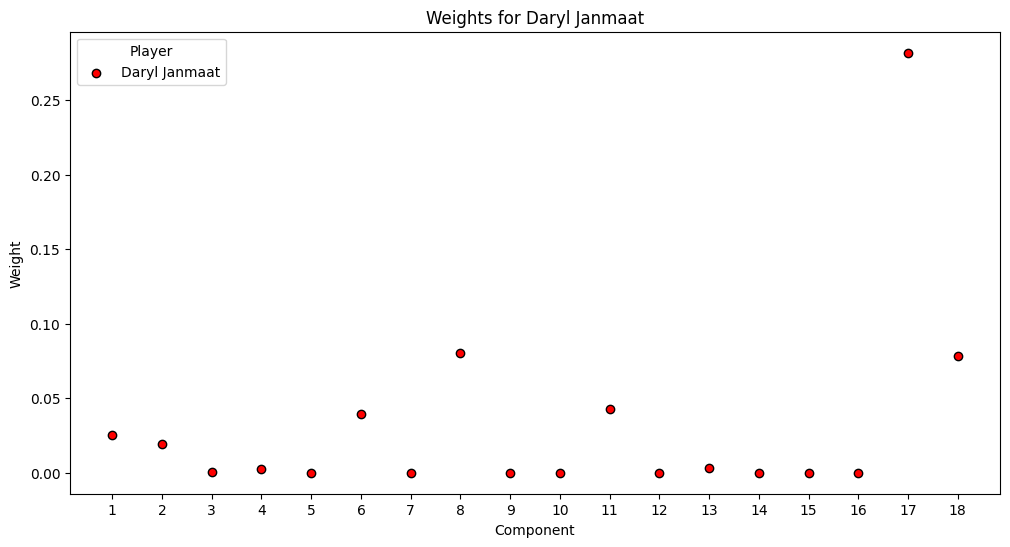

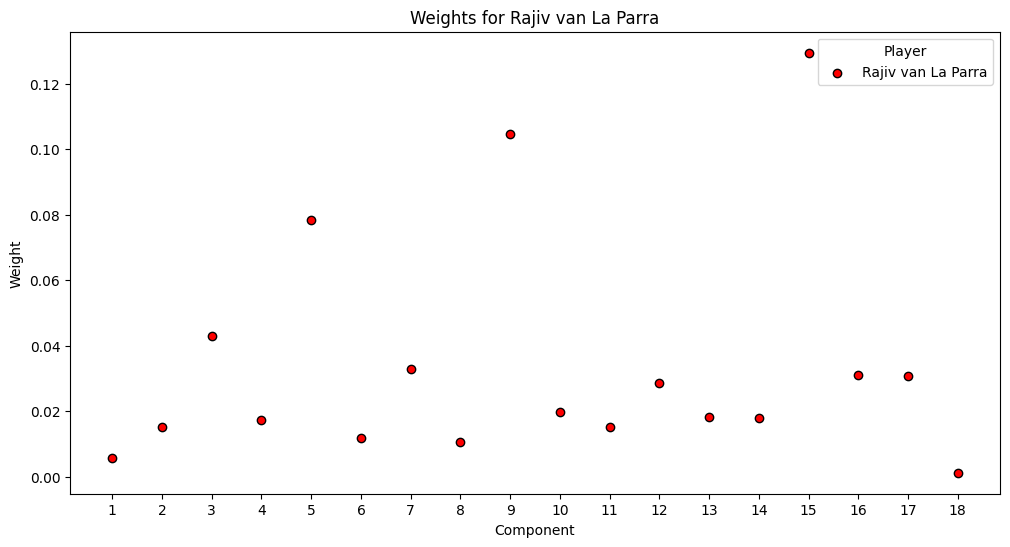

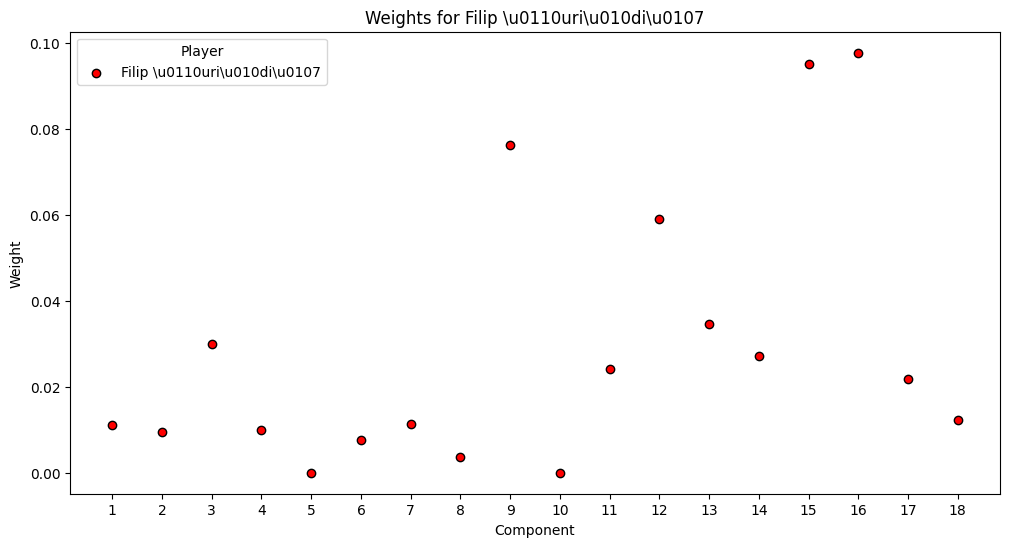

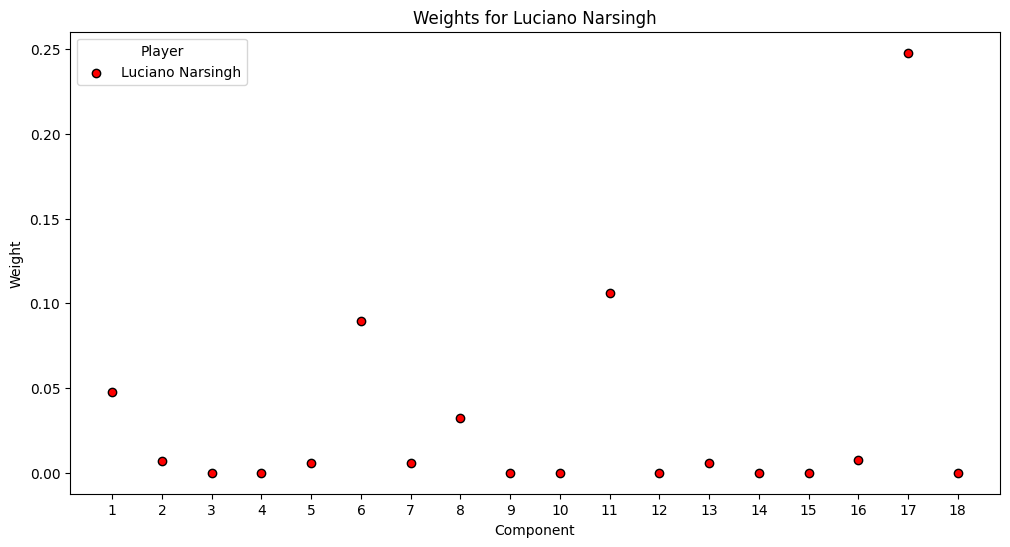

In [18]:
# Suppress the max open figure warning
plt.rcParams['figure.max_open_warning'] = 50

# Define the range of principal components
k_components = list(range(1, 19))

# Some plotting
for plot_count, (player_id, component_values) in enumerate(PVs.player_vectors.items()):
    player_name = playersID_to_name.get(player_id, '')
    
    # Ensure the component values contain the expected number of elements
    if len(component_values) == len(k_components) and player_name:
        plt.figure(figsize=(12, 6))  # Set figure size for better visualization
        plt.xlabel('Component')
        plt.ylabel('Weight')

        # Scatter plot of component weights for the player
        plt.scatter(
            k_components, 
            component_values, 
            color='red', 
            edgecolors='black', 
            label=player_name
        )
        plt.xticks(k_components)  # Set x-axis ticks for clarity
        plt.legend(title="Player")  # Add a legend with a title
        plt.title(f'Weights for {player_name}')  # Add a plot title

    # Limit the number of plots to prevent excessive rendering
    if plot_count >= 30:
        break

plt.show()  # Show all plots at the end
